In [1]:
import numpy as np
import tensorflow as tf
import sklearn as sk
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import  Lambda, Dense, Dropout, BatchNormalization, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.losses import mse, binary_crossentropy
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

In [2]:

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")


In [3]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [4]:
y_train_valid -= 769
y_test -= 769

In [5]:
def data_prep(X,y,person,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    total_person = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    total_person = person
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    print('Shape of y before averaging+noise and concatenating:',total_y.shape)
    print('Shape of person before averaging+noise and concatenating:',total_person.shape)
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    total_person = np.vstack((total_person, person))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    print('Shape of y after averaging+noise and concatenating:',total_y.shape)
    print('Shape of person after averaging+noise and concatenating:',total_person.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        total_person = np.vstack((total_person, person))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y,total_person


X_train_valid_prep,y_train_valid_prep,person_train_valid_pred = data_prep(X_train_valid,y_train_valid,person_train_valid,2,2,True)


Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of y before averaging+noise and concatenating: (2115,)
Shape of person before averaging+noise and concatenating: (2115, 1)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of y after averaging+noise and concatenating: (4230,)
Shape of person after averaging+noise and concatenating: (4230, 1)
Shape of X after subsampling and concatenating: (8460, 22, 250)


In [6]:
X_train_valid_prep,y_train_valid_prep,person_train_valid_prep = data_prep(X_train_valid,y_train_valid,person_train_valid,2,2,True)
X_test_prep,y_test_prep,person_test_prep = data_prep(X_test,y_test,person_test,2,2,True)

print(X_train_valid_prep.shape)
print(y_train_valid_prep.shape)
print(X_test_prep.shape)
print(y_test_prep.shape)



## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(8460, 1500, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
(person_train, person_valid) = person_train_valid_prep[ind_train], person_train_valid_prep[ind_valid] 
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of y before averaging+noise and concatenating: (2115,)
Shape of person before averaging+noise and concatenating: (2115, 1)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of y after averaging+noise and concatenating: (4230,)
Shape of person after averaging+noise and concatenating: (4230, 1)
Shape of X after subsampling and concatenating: (8460, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of y before averaging+noise and concatenating: (443,)
Shape of person before averaging+noise and concatenating: (443, 1)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of y after averaging+noise and concatenating: (886,)
Shape of person after averaging+noise and concatenating: (886, 1)
Shape of X after subsampling and concatenating: (1772, 22, 250)
(8460, 22, 250)
(8460,)
(1772, 22, 250)
(1772,)
Shape o

In [7]:
# from https://keras.io/examples/generative/vae/
class Sampling(layers.Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
# from https://keras.io/examples/generative/vae/
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        #self.accuracy_tracker = keras.metrics.Accuracy(name = 'accuracy')

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            #self.accuracy_tracker        
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
            #accuracy = self.accuracy_tracker.result()
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        #self.accuracy_tracker().update_state(accuracy)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            #"accuracy":self.accuracy_tracker.result()
        }
    

In [9]:
latent_dim = 2
vae_filts1 = 100

## Build Encoder
encoder_inputs = keras.Input(shape=(250,1,22))
x = layers.Conv2D(vae_filts1,(10,1),strides = (2,1), activation="relu",padding = 'same')(encoder_inputs)
conv_shape = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(200,activation = 'relu')(x)


#x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z_log_var += 1e-8
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


## Build the decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(200,activation = 'relu')(latent_inputs)
x = layers.Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation="relu")(x)
x = layers.Reshape((conv_shape[1],conv_shape[2],conv_shape[3]))(x)
decoder_outputs = layers.Conv2DTranspose(22,(10,1),strides=(2,1),activation = 'elu',padding='same')(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


vae = VAE(encoder, decoder)

2022-03-14 18:22:40.696866: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 1, 22)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 125, 1, 100)  22100       ['input_1[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 12500)        0           ['conv2d[0][0]']                 
                                                                                                  
 dense (Dense)                  (None, 200)          2500200     ['flatten[0][0]']          

In [10]:
learning_rate = 1e-3
decay = 1e-6
vae_optimizer = keras.optimizers.Adam(lr=learning_rate, decay = decay)

vae.compile(optimizer=vae_optimizer)
vae.fit(x_train, epochs = 30, batch_size=128, verbose = True)

/usr/local/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
55/55 [==============================] - 6s 95ms/step - loss: 383.7957 - reconstruction_loss: -1642.4207 - kl_loss: 752.4528
Epoch 2/30
55/55 [==============================] - 5s 82ms/step - loss: -2110.7718 - reconstruction_loss: -2695.8909 - kl_loss: 1014.7451
Epoch 3/30
55/55 [==============================] - 5s 83ms/step - loss: 56784.3424 - reconstruction_loss: -1960.7465 - kl_loss: 450778.4688
Epoch 4/30
55/55 [==============================] - 5s 87ms/step - loss: 1738207.8857 - reconstruction_loss: -4134.5410 - kl_loss: 491190.5000
Epoch 5/30
55/55 [==============================] - 6s 103ms/step - loss: -5016.9497 - reconstruction_loss: -5418.3774 - kl_loss: 293.1263
Epoch 6/30
55/55 [==============================] - 5s 97ms/step - loss: -4732.5621 - reconstruction_loss: -5525.7534 - kl_loss: 540.1835
Epoch 7/30
55/55 [==============================] - 5s 93ms/step - loss: -5323.9028 - reconstruction_loss: -5316.2080 - kl_loss: 0.0037
Epoch 8/30
55/55 [==========

In [11]:
#Passing real data through VAE to generate "fake" data
z_sample = vae.encoder([x_train])[2]
x_decoded = vae.decoder([z_sample])

Before VAE


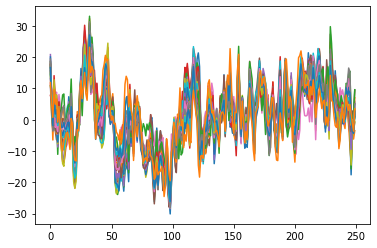

After VAE:


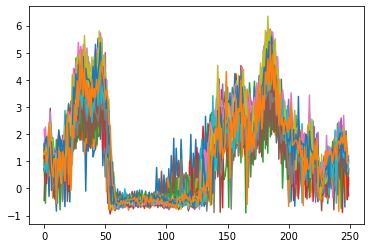

In [12]:
x_tane = x_train.reshape(6960,250,22)
print('Before VAE')
plt.plot(x_tane[5])
plt.show()

print('After VAE:')
x_vae = np.array(x_decoded).reshape(6960,250,22)
plt.plot(x_vae[1])
plt.show()

#Adding fake image data to existing real data
x_train3 = np.concatenate((x_train,x_decoded), axis = 0)
y_train3 = np.concatenate((y_train,y_train), axis = 0)

In [13]:
inputs = keras.Input(shape=(250, 1, 22))
x = Conv2D(50,(10,1),padding = 'same',activation = 'relu')(inputs)
x = MaxPooling2D(pool_size = (3,1), padding = 'same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Conv2D(100,(10,1),padding = 'same',activation = 'relu')(x)
x = MaxPooling2D(pool_size = (3,1), padding = 'same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Conv2D(200,(10,1),padding = 'same',activation = 'relu')(x)
x = MaxPooling2D(pool_size = (3,1), padding = 'same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)


x = Flatten()(x)
x = Dense(4)(x)
x = Activation('softmax')(x)
vae_cnn = Model(inputs,x, name = 'CNN')
vae_cnn_sub1 = Model(inputs,x, name = 'Subject1')
vae_cnn.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 250, 1, 22)]      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 1, 50)        11050     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 84, 1, 50)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 84, 1, 50)        200       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 84, 1, 50)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 84, 1, 100)        50100   

In [14]:
epochs = 50
optimizer = keras.optimizers.Adam(lr=learning_rate, decay = 1e-6)


# Compiling the model
vae_cnn.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Training and validating the model
vae_cnn_results = vae_cnn.fit(x_train3,
             y_train3,
             batch_size=64,
             epochs=epochs,
             validation_data = (x_valid,y_valid),
             verbose=True)

/usr/local/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
218/218 [==============================] - 16s 72ms/step - loss: 1.8176 - accuracy: 0.3000 - val_loss: 1.1818 - val_accuracy: 0.4907
Epoch 2/50
218/218 [==============================] - 14s 65ms/step - loss: 1.5050 - accuracy: 0.3509 - val_loss: 1.0695 - val_accuracy: 0.5487
Epoch 3/50
218/218 [==============================] - 14s 66ms/step - loss: 1.3674 - accuracy: 0.3848 - val_loss: 0.9413 - val_accuracy: 0.6400
Epoch 4/50
218/218 [==============================] - 15s 67ms/step - loss: 1.2823 - accuracy: 0.4146 - val_loss: 0.8878 - val_accuracy: 0.6540
Epoch 5/50
218/218 [==============================] - 14s 65ms/step - loss: 1.2306 - accuracy: 0.4299 - val_loss: 0.7940 - val_accuracy: 0.7027
Epoch 6/50
218/218 [==============================] - 15s 67ms/step - loss: 1.1686 - accuracy: 0.4527 - val_loss: 0.6939 - val_accuracy: 0.7507
Epoch 7/50
218/218 [==============================] - 14s 66ms/step - loss: 1.1449 - accuracy: 0.4614 - val_loss: 0.7335 - val_accuracy:

In [15]:
val_loss, val_acc = vae_cnn.evaluate(x_test,y_test)
print('VAE+CNN: ', val_loss,val_acc)

56/56 [==============================] - 1s 9ms/step - loss: 0.8777 - accuracy: 0.6817
VAE+CNN:  0.8776903748512268 0.6817155480384827


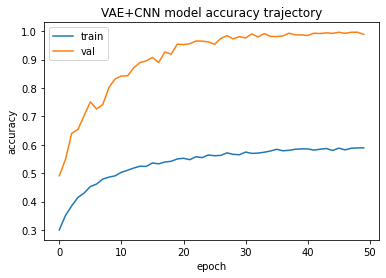

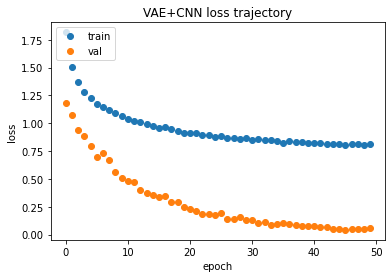

In [16]:
# Plotting accuracy trajectory
plt.plot(vae_cnn_results.history['accuracy'])
plt.plot(vae_cnn_results.history['val_accuracy'])
plt.title('VAE+CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(vae_cnn_results.history['loss'],'o')
plt.plot(vae_cnn_results.history['val_loss'],'o')
plt.title('VAE+CNN loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
vae_cnn.save('Charles_Xavier.model')
new_model = tf.keras.models.load_model('Charles_Xavier.model')

2022-03-14 18:37:26.625440: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Charles_Xavier.model/assets


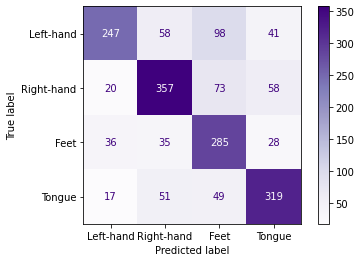

In [19]:
Y_pred = new_model.predict([x_test])
Y_pred = np.argmax(Y_pred, axis=1)
Y_test = np.argmax(y_test, axis=1)

labels = ["Left-hand", "Right-hand", "Feet", "Tongue"]
cm = confusion_matrix(Y_test, Y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Purples)
plt.show()

In [31]:
cnn_model = Sequential()

cnn_model.add(Conv2D(50,(10,1),padding = 'same',activation = 'relu',input_shape = (250,1,22)))
cnn_model.add(MaxPooling2D(pool_size = (3,1), padding = 'same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5))

cnn_model.add(Conv2D(100,(10,1),padding = 'same',activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = (3,1), padding = 'same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5))

cnn_model.add(Conv2D(200,(10,1),padding = 'same',activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size = (3,1), padding = 'same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5))

cnn_model.add(Flatten())
cnn_model.add(Dense(4))
cnn_model.add(Activation('softmax'))

In [32]:
learning_rate = 1e-3
epochs = 50
cnn_optimizer = keras.optimizers.Adam(lr=learning_rate, decay = 1e-6)


# Compiling the model
cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
cnn_model_results = model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

/usr/local/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
109/109 [==============================] - 6s 59ms/step - loss: 2.0572 - accuracy: 0.4652 - val_loss: 1.0414 - val_accuracy: 0.6173
Epoch 2/50
109/109 [==============================] - 7s 61ms/step - loss: 1.1946 - accuracy: 0.5754 - val_loss: 0.8188 - val_accuracy: 0.6840
Epoch 3/50
109/109 [==============================] - 7s 66ms/step - loss: 1.0054 - accuracy: 0.6208 - val_loss: 0.6625 - val_accuracy: 0.7440
Epoch 4/50
109/109 [==============================] - 7s 68ms/step - loss: 0.8556 - accuracy: 0.6671 - val_loss: 0.5919 - val_accuracy: 0.7960
Epoch 5/50
109/109 [==============================] - 8s 69ms/step - loss: 0.7787 - accuracy: 0.6990 - val_loss: 0.5455 - val_accuracy: 0.7993
Epoch 6/50
109/109 [==============================] - 7s 69ms/step - loss: 0.7295 - accuracy: 0.7221 - val_loss: 0.4668 - val_accuracy: 0.8427
Epoch 7/50
109/109 [==============================] - 8s 69ms/step - loss: 0.6357 - accuracy: 0.7519 - val_loss: 0.4550 - val_accuracy: 0.8360

In [34]:
val_loss, val_acc = cnn_model.evaluate(x_test,y_test)
print('Plain CNN: ', val_loss,val_acc)

56/56 [==============================] - 1s 9ms/step - loss: 7.4041 - accuracy: 0.2647
Plain CNN:  7.404141902923584 0.2646726965904236


In [20]:
test_idx_sub1 = np.where(person_test_prep==0)[0]
test_idx_sub2 = np.where(person_test_prep==1)[0]
test_idx_sub3 = np.where(person_test_prep==2)[0]
test_idx_sub4 = np.where(person_test_prep==3)[0]
test_idx_sub5 = np.where(person_test_prep==4)[0]
test_idx_sub6 = np.where(person_test_prep==5)[0]
test_idx_sub7 = np.where(person_test_prep==6)[0]
test_idx_sub8 = np.where(person_test_prep==7)[0]
test_idx_sub9 = np.where(person_test_prep==8)[0]

train_idx_sub1 = np.where(person_train==0)[0]
train_idx_sub2 = np.where(person_train==1)[0]
train_idx_sub3 = np.where(person_train==2)[0]
train_idx_sub4 = np.where(person_train==3)[0]
train_idx_sub5 = np.where(person_train==4)[0]
train_idx_sub6 = np.where(person_train==5)[0]
train_idx_sub7 = np.where(person_train==6)[0]
train_idx_sub8 = np.where(person_train==7)[0]
train_idx_sub9 = np.where(person_train==8)[0]

valid_idx_sub1 = np.where(person_valid==0)[0]
valid_idx_sub2 = np.where(person_valid==1)[0]
valid_idx_sub3 = np.where(person_valid==2)[0]
Valid_idx_sub4 = np.where(person_valid==3)[0]
valid_idx_sub5 = np.where(person_valid==4)[0]
valid_idx_sub6 = np.where(person_valid==5)[0]
valid_idx_sub7 = np.where(person_valid==6)[0]
valid_idx_sub8 = np.where(person_valid==7)[0]
valid_idx_sub9 = np.where(person_valid==8)[0]

In [21]:
x_train_sub1 = x_train3[train_idx_sub1]
y_train_sub1 = y_train3[train_idx_sub1]

x_valid_sub1 = x_valid[valid_idx_sub1]
y_valid_sub1 = y_valid[valid_idx_sub1]

x_test_sub1 = x_test[test_idx_sub1]
x_test_sub2 = x_test[test_idx_sub2]
x_test_sub3 = x_test[test_idx_sub3]
x_test_sub4 = x_test[test_idx_sub4]
x_test_sub5 = x_test[test_idx_sub5]
x_test_sub6 = x_test[test_idx_sub6]
x_test_sub7 = x_test[test_idx_sub7]
x_test_sub8 = x_test[test_idx_sub8]
x_test_sub9 = x_test[test_idx_sub9]

y_test_sub1 = y_test[test_idx_sub1]
y_test_sub2 = y_test[test_idx_sub2]
y_test_sub3 = y_test[test_idx_sub3]
y_test_sub4 = y_test[test_idx_sub4]
y_test_sub5 = y_test[test_idx_sub5]
y_test_sub6 = y_test[test_idx_sub6]
y_test_sub7 = y_test[test_idx_sub7]
y_test_sub8 = y_test[test_idx_sub8]
y_test_sub9 = y_test[test_idx_sub9]

In [ ]:
model = Sequential()

model.add(Conv2D(50,(10,1),padding = 'same',activation = 'relu',input_shape = (250,1,22)))
model.add(MaxPooling2D(pool_size = (3,1), padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv2D(100,(10,1),padding = 'same',activation = 'relu'))
model.add(MaxPooling2D(pool_size = (3,1), padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv2D(200,(10,1),padding = 'same',activation = 'relu'))
model.add(MaxPooling2D(pool_size = (3,1), padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(4))
model.add(Activation('softmax'))

In [24]:
#Optimize for Subject 1 now, because apparently the whole world revolves around him...


# Compiling the model
model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Training and validating the model
vae_cnn_results_sub1 = model.fit(x_train_sub1,
             y_train_sub1,
             batch_size=64,
             epochs=epochs,
             validation_data = (x_valid_sub1,y_valid_sub1),
             verbose=True)

Epoch 1/50
13/13 [==============================] - 2s 71ms/step - loss: 2.3042 - accuracy: 0.3843 - val_loss: 10.9008 - val_accuracy: 0.4235
Epoch 2/50
13/13 [==============================] - 1s 56ms/step - loss: 1.8329 - accuracy: 0.4627 - val_loss: 12.2151 - val_accuracy: 0.4941
Epoch 3/50
13/13 [==============================] - 1s 56ms/step - loss: 1.1676 - accuracy: 0.6131 - val_loss: 8.5792 - val_accuracy: 0.4353
Epoch 4/50
13/13 [==============================] - 1s 56ms/step - loss: 0.8566 - accuracy: 0.7159 - val_loss: 9.7617 - val_accuracy: 0.3824
Epoch 5/50
13/13 [==============================] - 1s 58ms/step - loss: 0.7729 - accuracy: 0.7506 - val_loss: 6.7944 - val_accuracy: 0.4529
Epoch 6/50
13/13 [==============================] - 1s 57ms/step - loss: 0.5339 - accuracy: 0.8278 - val_loss: 5.2995 - val_accuracy: 0.4412
Epoch 7/50
13/13 [==============================] - 1s 58ms/step - loss: 0.3918 - accuracy: 0.8728 - val_loss: 2.1037 - val_accuracy: 0.6588
Epoch 8/50


In [25]:
total_loss_sub1, total_acc_sub1 = model.evaluate(x_test, y_test)

56/56 [==============================] - 1s 9ms/step - loss: 5.0490 - accuracy: 0.3860


In [26]:
model.save('Sub1_opt.model')
sub1_opt_model = tf.keras.models.load_model('Sub1_opt.model')

INFO:tensorflow:Assets written to: Sub1_opt.model/assets


In [27]:
print('Optimizing for subject 1:')
print('Subject 1:')
sub1_loss1, sub1_accuracy1 = model.evaluate(x_test_sub1, y_test_sub1)
print('Subject 2:')
sub1_loss2, sub1_accuracy2 = model.evaluate(x_test_sub2, y_test_sub2)
print('Subject 3:')
sub1_loss3, sub1_accuracy3 = model.evaluate(x_test_sub3, y_test_sub3)
print('Subject 4:')
sub1_loss4, sub1_accuracy4 = model.evaluate(x_test_sub4, y_test_sub4)
print('Subject 5:')
sub1_loss5, sub1_accuracy5 = model.evaluate(x_test_sub5, y_test_sub5)
print('Subject 6:')
sub1_loss6, sub1_accuracy6 = model.evaluate(x_test_sub6, y_test_sub6)
print('Subject 7:')
sub1_loss7, sub1_accuracy7 = model.evaluate(x_test_sub7, y_test_sub7)
print('Subject 8:')
sub1_loss8, sub1_accuracy8 = model.evaluate(x_test_sub8, y_test_sub8)
print('Subject 9:')
sub1_loss9, sub1_accuracy9 = model.evaluate(x_test_sub9, y_test_sub9)


Optimizing for subject 1:
Subject 1:
7/7 [==============================] - 0s 8ms/step - loss: 2.0223 - accuracy: 0.6400
Subject 2:
7/7 [==============================] - 0s 10ms/step - loss: 3.5998 - accuracy: 0.3300
Subject 3:
7/7 [==============================] - 0s 10ms/step - loss: 2.4767 - accuracy: 0.5100
Subject 4:
7/7 [==============================] - 0s 9ms/step - loss: 4.3279 - accuracy: 0.3400
Subject 5:
6/6 [==============================] - 0s 9ms/step - loss: 7.0079 - accuracy: 0.3032
Subject 6:
7/7 [==============================] - 0s 8ms/step - loss: 7.9799 - accuracy: 0.2806
Subject 7:
7/7 [==============================] - 0s 9ms/step - loss: 4.6421 - accuracy: 0.3750
Subject 8:
7/7 [==============================] - 0s 8ms/step - loss: 6.7970 - accuracy: 0.3650
Subject 9:
6/6 [==============================] - 0s 10ms/step - loss: 6.8728 - accuracy: 0.3191


In [29]:
print('Optimizing for all subjects:')
print('Subject 1:')
sub1_loss, all_accuracy1 = vae_cnn.evaluate(x_test_sub1, y_test_sub1)
print('Subject 2:')
sub2_loss, all_accuracy2 = vae_cnn.evaluate(x_test_sub2, y_test_sub2)
print('Subject 3:')
sub3_loss, all_accuracy3 = vae_cnn.evaluate(x_test_sub3, y_test_sub3)
print('Subject 4:')
sub4_loss, all_accuracy4 = vae_cnn.evaluate(x_test_sub4, y_test_sub4)
print('Subject 5:')
sub5_loss, all_accuracy5 = vae_cnn.evaluate(x_test_sub5, y_test_sub5)
print('Subject 6:')
sub6_loss, all_accuracy6 = vae_cnn.evaluate(x_test_sub6, y_test_sub6)
print('Subject 7:')
sub7_loss, all_accuracy7 = vae_cnn.evaluate(x_test_sub7, y_test_sub7)
print('Subject 8:')
sub8_loss, all_accuracy8 = vae_cnn.evaluate(x_test_sub8, y_test_sub8)
print('Subject 9:')
sub9_loss, all_accuracy9 = vae_cnn.evaluate(x_test_sub9, y_test_sub9)


Optimizing for all subjects:
Subject 1:
7/7 [==============================] - 0s 9ms/step - loss: 0.7469 - accuracy: 0.7550
Subject 2:
7/7 [==============================] - 0s 10ms/step - loss: 1.2694 - accuracy: 0.5050
Subject 3:
7/7 [==============================] - 0s 9ms/step - loss: 0.6386 - accuracy: 0.7600
Subject 4:
7/7 [==============================] - 0s 9ms/step - loss: 0.7649 - accuracy: 0.7200
Subject 5:
6/6 [==============================] - 0s 9ms/step - loss: 1.0479 - accuracy: 0.6968
Subject 6:
7/7 [==============================] - 0s 8ms/step - loss: 1.5027 - accuracy: 0.6429
Subject 7:
7/7 [==============================] - 0s 9ms/step - loss: 1.2976 - accuracy: 0.5950
Subject 8:
7/7 [==============================] - 0s 8ms/step - loss: 1.2191 - accuracy: 0.6450
Subject 9:
6/6 [==============================] - 0s 11ms/step - loss: 1.2512 - accuracy: 0.7128


Optimizing for subject 1:


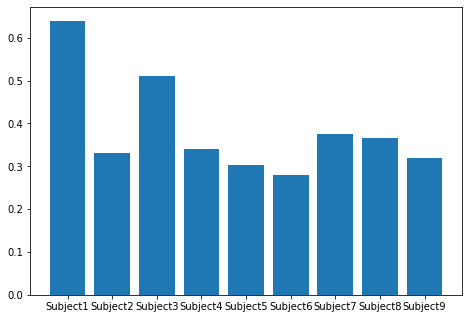

Optimizing for all subjects:


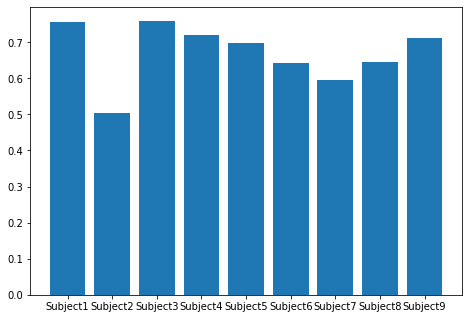

In [30]:
subject_labels = ['Subject1','Subject2','Subject3','Subject4','Subject5','Subject6','Subject7','Subject8','Subject9',]
subject1_optimization_accuracies = [sub1_accuracy1,sub1_accuracy2,sub1_accuracy3,sub1_accuracy4,sub1_accuracy5,sub1_accuracy6,sub1_accuracy7,sub1_accuracy8,sub1_accuracy9]
all_optimization_accuracies = [all_accuracy1,all_accuracy2,all_accuracy3,all_accuracy4,all_accuracy5,all_accuracy6,all_accuracy7,all_accuracy8,all_accuracy9]


ax = plt.figure().add_axes([0,0,1,1])
print('Optimizing for subject 1:')
ax.bar(subject_labels,subject1_optimization_accuracies)
plt.show()

bx = plt.figure().add_axes([0,0,1,1])
print('Optimizing for all subjects:')
bx.bar(subject_labels,all_optimization_accuracies)
plt.show()


In [75]:
# training for varying times
time50_model = Sequential()

time50_model.add(Conv2D(50,(10,1),padding = 'same',activation = 'relu',input_shape = (50,1,22)))
time50_model.add(MaxPooling2D(pool_size = (3,1), padding = 'same'))
time50_model.add(BatchNormalization())
time50_model.add(Dropout(0.5))

time50_model.add(Conv2D(100,(10,1),padding = 'same',activation = 'relu'))
time50_model.add(MaxPooling2D(pool_size = (3,1), padding = 'same'))
time50_model.add(BatchNormalization())
time50_model.add(Dropout(0.5))

time50_model.add(Conv2D(200,(10,1),padding = 'same',activation = 'relu'))
time50_model.add(MaxPooling2D(pool_size = (3,1), padding = 'same'))
time50_model.add(BatchNormalization())
time50_model.add(Dropout(0.5))

time50_model.add(Flatten())
time50_model.add(Dense(4))
time50_model.add(Activation('softmax'))

time100_model = Sequential()

time100_model.add(Conv2D(50,(10,1),padding = 'same',activation = 'relu',input_shape = (100,1,22)))
time100_model.add(MaxPooling2D(pool_size = (3,1), padding = 'same'))
time100_model.add(BatchNormalization())
time100_model.add(Dropout(0.5))

time100_model.add(Conv2D(100,(10,1),padding = 'same',activation = 'relu'))
time100_model.add(MaxPooling2D(pool_size = (3,1), padding = 'same'))
time100_model.add(BatchNormalization())
time100_model.add(Dropout(0.5))

time100_model.add(Conv2D(200,(10,1),padding = 'same',activation = 'relu'))
time100_model.add(MaxPooling2D(pool_size = (3,1), padding = 'same'))
time100_model.add(BatchNormalization())
time100_model.add(Dropout(0.5))

time100_model.add(Flatten())
time100_model.add(Dense(4))
time100_model.add(Activation('softmax'))

time150_model = Sequential()

time150_model.add(Conv2D(50,(10,1),padding = 'same',activation = 'relu',input_shape = (150,1,22)))
time150_model.add(MaxPooling2D(pool_size = (3,1), padding = 'same'))
time150_model.add(BatchNormalization())
time150_model.add(Dropout(0.5))

time150_model.add(Conv2D(100,(10,1),padding = 'same',activation = 'relu'))
time150_model.add(MaxPooling2D(pool_size = (3,1), padding = 'same'))
time150_model.add(BatchNormalization())
time150_model.add(Dropout(0.5))

time150_model.add(Conv2D(200,(10,1),padding = 'same',activation = 'relu'))
time150_model.add(MaxPooling2D(pool_size = (3,1), padding = 'same'))
time150_model.add(BatchNormalization())
time150_model.add(Dropout(0.5))

time150_model.add(Flatten())
time150_model.add(Dense(4))
time150_model.add(Activation('softmax'))

time200_model = Sequential()

time200_model.add(Conv2D(50,(10,1),padding = 'same',activation = 'relu',input_shape = (200,1,22)))
time200_model.add(MaxPooling2D(pool_size = (3,1), padding = 'same'))
time200_model.add(BatchNormalization())
time200_model.add(Dropout(0.5))

time200_model.add(Conv2D(100,(10,1),padding = 'same',activation = 'relu'))
time200_model.add(MaxPooling2D(pool_size = (3,1), padding = 'same'))
time200_model.add(BatchNormalization())
time200_model.add(Dropout(0.5))

time200_model.add(Conv2D(200,(10,1),padding = 'same',activation = 'relu'))
time200_model.add(MaxPooling2D(pool_size = (3,1), padding = 'same'))
time200_model.add(BatchNormalization())
time200_model.add(Dropout(0.5))

time200_model.add(Flatten())
time200_model.add(Dense(4))
time200_model.add(Activation('softmax'))

In [76]:
#50
x_train_time50 = x_train[:,0:50,:,:]
x_valid_time50 = x_valid[:,0:50,:,:]
x_test_time50 = x_test[:,0:50,:,:]

#100
x_train_time100 = x_train[:,0:100,:,:]
x_valid_time100 = x_valid[:,0:100,:,:]
x_test_time100 = x_test[:,0:100,:,:]

#150
x_train_time150 = x_train[:,0:150,:,:]
x_valid_time150 = x_valid[:,0:150,:,:]
x_test_time150 = x_test[:,0:150,:,:]

#200
x_train_time200 = x_train[:,0:200,:,:]
x_valid_time200 = x_valid[:,0:200,:,:]
x_test_time200 = x_test[:,0:200,:,:]

In [63]:
# Compiling the model
time50_model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Training and validating the model
time50_results = time50_model.fit(x_train_time50,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data = (x_valid_time50,y_valid),
             verbose=True)

Epoch 1/50
109/109 [==============================] - 3s 20ms/step - loss: 1.7148 - accuracy: 0.3009 - val_loss: 1.5548 - val_accuracy: 0.3373
Epoch 2/50
109/109 [==============================] - 2s 19ms/step - loss: 1.3995 - accuracy: 0.3524 - val_loss: 1.3214 - val_accuracy: 0.3740
Epoch 3/50
109/109 [==============================] - 2s 19ms/step - loss: 1.3351 - accuracy: 0.3855 - val_loss: 1.2577 - val_accuracy: 0.3993
Epoch 4/50
109/109 [==============================] - 2s 19ms/step - loss: 1.2751 - accuracy: 0.4210 - val_loss: 1.2250 - val_accuracy: 0.4353
Epoch 5/50
109/109 [==============================] - 2s 19ms/step - loss: 1.2559 - accuracy: 0.4286 - val_loss: 1.1892 - val_accuracy: 0.4600
Epoch 6/50
109/109 [==============================] - 2s 20ms/step - loss: 1.2058 - accuracy: 0.4583 - val_loss: 1.1894 - val_accuracy: 0.4573
Epoch 7/50
109/109 [==============================] - 2s 19ms/step - loss: 1.1627 - accuracy: 0.4875 - val_loss: 1.1010 - val_accuracy: 0.5367

In [66]:
# Compiling the model
time100_model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Training and validating the model
time100_results = time100_model.fit(x_train_time100,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data = (x_valid_time100,y_valid),
             verbose=True)

Epoch 1/50
109/109 [==============================] - 4s 30ms/step - loss: 1.8273 - accuracy: 0.3280 - val_loss: 1.7267 - val_accuracy: 0.3473
Epoch 2/50
109/109 [==============================] - 3s 28ms/step - loss: 1.3906 - accuracy: 0.3866 - val_loss: 1.2267 - val_accuracy: 0.4513
Epoch 3/50
109/109 [==============================] - 3s 29ms/step - loss: 1.2762 - accuracy: 0.4362 - val_loss: 1.1811 - val_accuracy: 0.4773
Epoch 4/50
109/109 [==============================] - 3s 29ms/step - loss: 1.2095 - accuracy: 0.4757 - val_loss: 1.1213 - val_accuracy: 0.5247
Epoch 5/50
109/109 [==============================] - 3s 29ms/step - loss: 1.1404 - accuracy: 0.5043 - val_loss: 1.0453 - val_accuracy: 0.5513
Epoch 6/50
109/109 [==============================] - 3s 30ms/step - loss: 1.0944 - accuracy: 0.5342 - val_loss: 0.9667 - val_accuracy: 0.6020
Epoch 7/50
109/109 [==============================] - 4s 32ms/step - loss: 1.0284 - accuracy: 0.5659 - val_loss: 0.9151 - val_accuracy: 0.6213

In [77]:
# Compiling the model
time150_model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Training and validating the model
time_results = time150_model.fit(x_train_time150,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data = (x_valid_time150,y_valid),
             verbose=True)

Epoch 1/50
109/109 [==============================] - 5s 40ms/step - loss: 1.9047 - accuracy: 0.3282 - val_loss: 1.7157 - val_accuracy: 0.3847
Epoch 2/50
109/109 [==============================] - 4s 40ms/step - loss: 1.3520 - accuracy: 0.4319 - val_loss: 1.0845 - val_accuracy: 0.5433
Epoch 3/50
109/109 [==============================] - 5s 42ms/step - loss: 1.2196 - accuracy: 0.4928 - val_loss: 1.0646 - val_accuracy: 0.5307
Epoch 4/50
109/109 [==============================] - 5s 46ms/step - loss: 1.1061 - accuracy: 0.5388 - val_loss: 0.9951 - val_accuracy: 0.5820
Epoch 5/50
109/109 [==============================] - 5s 44ms/step - loss: 1.0290 - accuracy: 0.5737 - val_loss: 0.8615 - val_accuracy: 0.6540
Epoch 6/50
109/109 [==============================] - 5s 47ms/step - loss: 0.9419 - accuracy: 0.6082 - val_loss: 0.8172 - val_accuracy: 0.6653
Epoch 7/50
109/109 [==============================] - 5s 45ms/step - loss: 0.8979 - accuracy: 0.6318 - val_loss: 0.7718 - val_accuracy: 0.7040

In [83]:
# Compiling the model
time200_model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Training and validating the model
time200_results = time200_model.fit(x_train_time200,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data = (x_valid_time200,y_valid),
             verbose=True)

Epoch 1/50
109/109 [==============================] - 6s 50ms/step - loss: 2.0689 - accuracy: 0.3432 - val_loss: 1.7208 - val_accuracy: 0.4227
Epoch 2/50
109/109 [==============================] - 5s 48ms/step - loss: 1.4201 - accuracy: 0.4392 - val_loss: 1.0444 - val_accuracy: 0.5527
Epoch 3/50
109/109 [==============================] - 6s 51ms/step - loss: 1.2439 - accuracy: 0.4865 - val_loss: 1.0124 - val_accuracy: 0.5667
Epoch 4/50
109/109 [==============================] - 6s 54ms/step - loss: 1.0818 - accuracy: 0.5537 - val_loss: 0.8866 - val_accuracy: 0.6520
Epoch 5/50
109/109 [==============================] - 6s 58ms/step - loss: 0.9750 - accuracy: 0.6029 - val_loss: 0.7963 - val_accuracy: 0.6927
Epoch 6/50
109/109 [==============================] - 6s 58ms/step - loss: 0.9118 - accuracy: 0.6323 - val_loss: 0.7274 - val_accuracy: 0.7273
Epoch 7/50
109/109 [==============================] - 6s 58ms/step - loss: 0.8142 - accuracy: 0.6690 - val_loss: 0.6854 - val_accuracy: 0.7413

In [68]:
acc_time50, acc_time50 = time50_model.evaluate(x_test_time50, y_test)

56/56 [==============================] - 0s 3ms/step - loss: 1.3296 - accuracy: 0.5147


In [69]:
acc_time100, acc_time100 = time100_model.evaluate(x_test_time100, y_test)

56/56 [==============================] - 0s 4ms/step - loss: 1.1172 - accuracy: 0.6050


In [81]:
acc_time150, acc_time150 = time150_model.evaluate(x_test_time150, y_test)

56/56 [==============================] - 0s 5ms/step - loss: 1.1131 - accuracy: 0.6693


In [84]:
acc_time200, acc_time200 = time200_model.evaluate(x_test_time200, y_test)

56/56 [==============================] - 0s 7ms/step - loss: 1.0794 - accuracy: 0.6648


In [87]:
# for first  50 time units: 0.507
# for first 100 time units: 0.647
# for first 150 time units: 0.652
# for first 200 time units: 
# for first 250 time units:

from tabulate import tabulate
tabledata = [
    [' 50 seconds',acc_time50],
    ['100 seconds',acc_time100],
    ['150 seconds',acc_time150],
    ['200 seconds',acc_time200]
]

tablehead = ['Time Period','Test Accuracy']

print(tabulate(tabledata, headers=tablehead, tablefmt="grid"))

+---------------+-----------------+
| Time Period   |   Test Accuracy |
+===============+=================+
| 50 seconds    |        0.514673 |
+---------------+-----------------+
| 100 seconds   |        0.604966 |
+---------------+-----------------+
| 150 seconds   |        0.6693   |
+---------------+-----------------+
| 200 seconds   |        0.664786 |
+---------------+-----------------+
